In [11]:
%pip install umap-learn

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.43ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [12]:
import os
import warnings
warnings.filterwarnings('ignore')

while not os.path.isfile("README.md"):
    %cd ..

import umap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.utils import compute_sample_weight
import lightgbm as lgb
from lib.preprocess import Preprocess

pd.set_option('display.max_colwidth', None)
BASE_PATH = os.path.abspath("")

In [13]:
def set_seed(seed=42):
    np.random.seed(seed)  # 🎲 Set seed for NumPy
    torch.manual_seed(seed)  # 🚀 Set seed for PyTorch on CPU
    torch.cuda.manual_seed(seed)  # 🚀 Set seed for PyTorch on GPU
    
    # ⚙️ When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # 🔏 Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)

In [14]:
ppr = Preprocess()
X_train, y_train, X_test = ppr.get_data()

In [15]:
object_columns = X_train.select_dtypes(include=["object"]).columns # get all categorical feature columns
date_columns = ["ApprovalDate", "DisbursementDate"]
money_columns = ["DisbursementGross", "GrAppv", "SBA_Appv"]
categorical_columns = ['RevLineCr', 'LowDoc', 'City', 'State', 'BankState']

In [16]:
day_map = lambda s: float(s)
month_map = {
    "Jan": 1,
    "Feb": 2,
    "Mar": 3,
    "Apr": 4,
    "May": 5,
    "Jun": 6,
    "Jul": 7,
    "Aug": 8,
    "Sep": 9,
    "Oct": 10,
    "Nov": 11,
    "Dec": 12
}
year_map = lambda s: float("20"+s) if float(s) < 50 else float("19"+s) if float(s)>50 else s
datemaps_dict = {
    "day": day_map,
    "month": month_map,
    "year": year_map,
}

In [17]:
y_train.loc[X_train[date_columns].isna().any(axis=1)].value_counts()

1    94
0    56
Name: MIS_Status, dtype: int64

In [18]:
X_test[date_columns].isna().any(axis=1).sum()

160

In [19]:
X_train = X_train.dropna(subset=date_columns)
y_train = y_train.loc[X_train.index]
X_test = X_test.dropna(subset=date_columns)

In [20]:
for datecol in date_columns:
    for i, (key, mapfunc) in enumerate(datemaps_dict.items()):
        X_train[datecol + "_" + key] = X_train[datecol].str.split("-").str[i].map(mapfunc)
        X_train[datecol + "_" + key] = X_train[datecol + "_" + key].astype(float)
        X_test[datecol + "_" + key] = X_test[datecol].str.split("-").str[i].map(mapfunc)
        X_test[datecol + "_" + key] = X_test[datecol + "_" + key].astype(float)

In [21]:
X_train[money_columns]= X_train[money_columns].applymap(lambda x: x.strip().replace('$', '').replace(',', '')).astype(float)
X_test[money_columns]= X_test[money_columns].applymap(lambda x: x.strip().replace('$', '').replace(',', '')).astype(float)

In [22]:
X_train[categorical_columns] = X_train[categorical_columns].fillna("NaN")
X_test[categorical_columns] = X_test[categorical_columns].fillna("NaN")
oe_dict = dict()
for col in categorical_columns:
    oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X_train.loc[:,col] = oe.fit_transform(X_train.loc[:,col].values.reshape(-1, 1))
    X_test.loc[:,col] = oe.transform(X_test.loc[:,col].values.reshape(-1, 1))
    X_train[col] = X_train[col].astype(float)
    X_test[col] = X_test[col].astype(float)
    oe_dict[col] = oe
X_train = X_train.drop(date_columns, axis=1)
X_test = X_test.drop(date_columns, axis=1)

In [23]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2)
embedding = reducer.fit_transform(X_train)

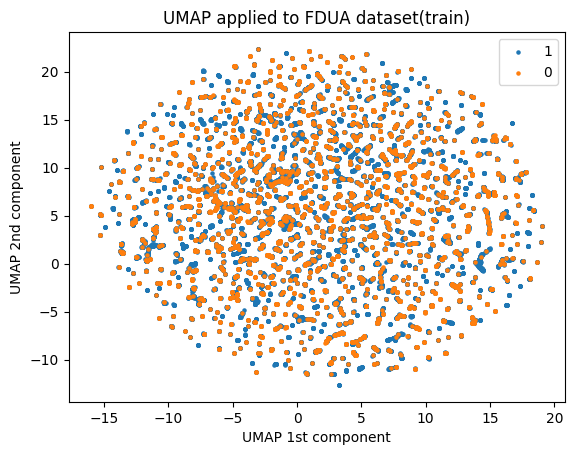

In [24]:
unique_targets = sorted(list(set(y_train)), reverse=True) # get all unique targets; sort in descending order(according to the number of samples)
for t in unique_targets:
    indices = [i for i, value in enumerate(y_train) if value == t]
    plt.scatter(embedding[indices, 0], embedding[indices, 1], label=t,  s=5)

plt.xlabel('UMAP 1st component')
plt.ylabel('UMAP 2nd component')
plt.title('UMAP applied to FDUA dataset(train)')

plt.legend()

plt.show()

In [25]:
embedding = reducer.transform(X_test)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


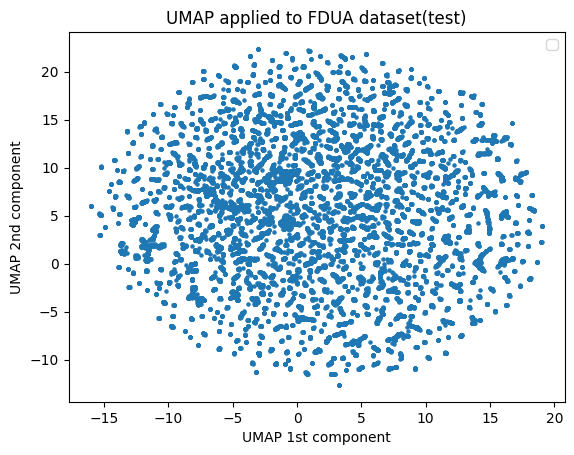

In [26]:
plt.scatter(embedding[:, 0], embedding[:, 1],  s=5)

plt.xlabel('UMAP 1st component')
plt.ylabel('UMAP 2nd component')
plt.title('UMAP applied to FDUA dataset(test)')

plt.legend()

plt.show()

In [27]:
%pip install plyer
from plyer import notification

notification.notify(
    title="From Python",
    message="Executed Successfully",
    app_name='Python',
    app_icon=os.path.join(BASE_PATH,'lib/notification.ico'),
)

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.43ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.
